In [11]:
import numpy as np, random
from typing import Tuple
import time
import matplotlib.pyplot as plt

### python 版本的monte carlo

In [2]:
def mc_simulate_ruin(i: int, m: int, p: float, trials: int) -> Tuple[float, float, np.ndarray, np.ndarray]:
    """
    同時回傳
      1) 破產率 ruin_rate
      2) 平均步數 avg_steps
      3) 每次遊戲持續步數 durations (長度=trials)
      4) 每次是否破產旗標 ruin_flags (長度=trials)
    """
    durations  = np.zeros(trials, dtype=int)
    ruin_flags = np.zeros(trials, dtype=int)
    ruin_count = 0
    total_steps = 0

    for t in range(trials):
        k, steps = i, 0
        # 模擬一條路徑
        while 0 < k < m:
            if random.random() < p:
                k += 1
            else:
                k -= 1
            steps += 1

        durations[t]  = steps
        ruin_flags[t] = int(k == 0)

        if k == 0:
            ruin_count += 1
        total_steps += steps

    ruin_rate = ruin_count / trials
    avg_steps = total_steps / trials

    return ruin_rate, avg_steps

### Cython 版本的monte carlo

In [3]:
# 在 Jupyter Notebook 中撰寫 Cython 版 simulate_ruin
# 1. 載入 Cython Magic
%load_ext cython

In [4]:
%%cython
# cython: boundscheck=False, wraparound=False
import random
cimport cython
from libc.stdlib cimport rand, RAND_MAX

@cython.boundscheck(False)
def mc_simulate_ruin_cy(int i, int m, double p, int trials):
    """
    Cython 優化的 Monte Carlo 模擬 Gambler's Ruin
    返回 (破產機率, 平均步數)
    """
    cdef int ruin_count = 0
    cdef long total_steps = 0
    cdef int t, k, steps
    cdef double r
    for t in range(trials):
        k = i
        steps = 0
        while 0 < k < m:
            # 用 C rand() 加速隨機抽樣
            r = rand() / <double>RAND_MAX
            if r < p:
                k += 1
            else:
                k -= 1
            steps += 1
        if k == 0:
            ruin_count += 1
        total_steps += steps
    return ruin_count / trials, total_steps / trials

### C++ 版本的monte carlo

In [5]:
import c_monte

In [6]:
# 測試參數
i, m, p, trials = 10, 100, 0.48, 100_000

In [7]:
# 計時開始
start = time.time()
ruin_rate, avg_steps, avg_rtp = c_monte.monte_carlo_sim(i, m, p, trials)
cpp_time = time.time() - start

print(f"破產率={ruin_rate:.4f}, 平均步數={avg_steps:.1f}, 平均RTP={avg_rtp:.4f}")

破產率=0.9995, 平均步數=249.0, 平均RTP=0.0005


In [8]:
# 純 Python
start = time.time()
r_py, d_py = mc_simulate_ruin(i, m, p, trials)
py_time = time.time() - start

# Cython
start = time.time()
r_cy, d_cy = mc_simulate_ruin_cy(i, m, p, trials)
cy_time = time.time() - start

In [9]:
# C++ (前面已跑過 cpp_time)
print(f"純 Python: {py_time:.3f}s, 破產率={r_py:.4f}, 平均步數={d_py:.1f}")
print(f"Cython:    {cy_time:.3f}s, 破產率={r_cy:.4f}, 平均步數={d_cy:.1f}")
print(f"C++:       {cpp_time:.3f}s, 破產率={ruin_rate:.4f}, 平均步數={avg_steps:.1f}")
print(f"加速比 (C++/Python): {py_time/cpp_time:.1f}×")

純 Python: 6.128s, 破產率=0.9995, 平均步數=249.0
Cython:    0.495s, 破產率=0.9995, 平均步數=248.8
C++:       0.133s, 破產率=0.9995, 平均步數=249.0
加速比 (C++/Python): 46.1×


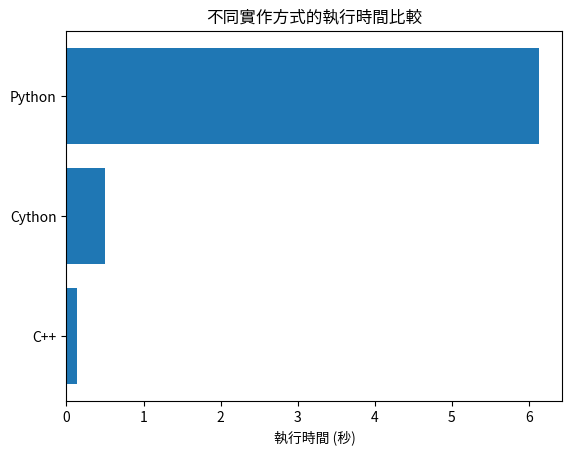

In [12]:
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

methods = ['Python', 'Cython', 'C++']
times = [6.128, 0.495, 0.133]

plt.barh(methods, times)
plt.xlabel("執行時間 (秒)")
plt.title("不同實作方式的執行時間比較")
plt.gca().invert_yaxis()
plt.show()